# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import torch
import numpy as np
import math
import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import keras.backend as K
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
import cv2
from sklearn.metrics import roc_auc_score, f1_score
import joblib

# Google Drive Connect



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data loading

In [ ]:
# Load train and test splits.
data = pd.read_csv("/content/drive/MyDrive/ECE1512ProjA/annotations.csv")
data.head()

,Image,Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [ ]:
Train = []
Tlabel = []#1 for SSA,0 for HP
Val = []
Vlabel = []
for i,p in enumerate(data.Partition):
  img = cv2.imread("/content/drive/MyDrive/ECE1512ProjA/images/" + data.Image[i])
  label = 1 if data.Label[i] == "SSA" else 0
  #print(label,data.Label[i])
  if p == "train":
    Train.append(img)
    Tlabel.append(label)
  else:
    Val.append(img)
    Vlabel.append(label)

In [ ]:
#Flip=
length = len(Train)
for i in range(length):
  IMG = np.fliplr(Train[i])
  Train.append(IMG)
  Tlabel.append(Tlabel[i])

In [ ]:
#Rotate
length = len(Train)
for i in range(length):
  Train.append(np.rot90(Train[i],2))
  Tlabel.append(Tlabel[i])

In [ ]:
np.save("/content/drive/MyDrive/ECE1512ProjA/Train.npy",Train)
np.save("/content/drive/MyDrive/ECE1512ProjA/Tlabel.npy",Tlabel)
np.save("/content/drive/MyDrive/ECE1512ProjA/Val.npy",Val)
np.save("/content/drive/MyDrive/ECE1512ProjA/Vlabel.npy",Vlabel)

In [4]:
Train = np.load("/content/drive/MyDrive/ECE1512ProjA/Train.npy")
Tlabel = np.load("/content/drive/MyDrive/ECE1512ProjA/Tlabel.npy")
Val = np.load("/content/drive/MyDrive/ECE1512ProjA/Val.npy")
Vlabel = np.load("/content/drive/MyDrive/ECE1512ProjA/Vlabel.npy")

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.labels = labels

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # print(index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = ID
            y[i] = self.labels[i]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [6]:
TRAIN= DataGenerator(Train,Tlabel)
Val= DataGenerator(Val,Vlabel)

# Model creation

In [7]:
def teacher(dr):
  base_teacher = tf.keras.applications.resnet_v2.ResNet50V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
  imgs = base_teacher.input
  midput = base_teacher(imgs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  midput = keras.layers.GlobalMaxPooling2D()(midput)
  midput = keras.layers.Dropout(dr)(midput)
  outputs = Dense(2)(midput)
  teacher_model = keras.Model(imgs, outputs)
  return base_teacher,teacher_model

def student():
  base_student = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
  simgs = base_student.input
  smidput = base_student(simgs, training=False)
  smidput = keras.layers.GlobalAveragePooling2D()(smidput)
  soutputs = Dense(2)(smidput)
  student_model = keras.Model(simgs, soutputs)
  return base_student,student_model


# Teacher loss function

In [8]:
@tf.function
def compute_teacher_loss(base,teacher_model,images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)
  #print(subclass_logits[0][0],labels)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,subclass_logits)
  return cross_entropy_loss_value

# Student loss function

In [9]:
#test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.4 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 32. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)
  #np.exp(student_logits/temperature)/sum(np.exp(student_logits/temperature))

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(teacher_model,student_model,images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  teacher_subclass_logits = teacher_model(images, training=False)
  
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,student_subclass_logits)

  return (ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value)

# Train and evaluation

In [10]:
def train_and_evaluate(base,model, compute_loss_fn, NUM_EPOCHS,lr):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracy = []
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  # length = len(TRAIN)
  # lengthV = len(Val)
  f1 = []


  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for X, y in TRAIN:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(base,model,X,y)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
    print(loss_value)
    # Run evaluation.
    PRE = []
    y2 = []
    for X1, y1 in Val:
      predict = model(X1,training=False)
      for i, SET in enumerate(predict):
        if SET[1] > SET[0]:
          PRE.append([0,1])
          y2.append(y1[i])
        else:
          PRE.append([1,0])
          y2.append(y1[i])
    # print(PRE)
    # print(y2)
    f1score = f1_score(y2,PRE,average = "weighted")
    print(f1score)
    f1.append(f1score)

  return f1


# Training models

In [ ]:
# your code start from here for step 5 
# Train the teacher model
base_teacher1,teacher_model1 = teacher(0)
base_teacher1.trainable = False
inif1t1 = train_and_evaluate(base_teacher1,teacher_model1,compute_teacher_loss,10,1e-4)
#fine-tuning
base_teacher1.trainable = True
finalf1t1 = train_and_evaluate(base_teacher1,teacher_model1,compute_teacher_loss,25,1e-5)

94668760/94668760 [==============================] - 0s 0us/step
Epoch 1: tf.Tensor(30.388521, shape=(), dtype=float32)
0.6947433482971229
Epoch 2: tf.Tensor(25.671967, shape=(), dtype=float32)
0.7183883004495168
Epoch 3: tf.Tensor(23.341824, shape=(), dtype=float32)
0.7038875688912231
Epoch 4: tf.Tensor(21.84421, shape=(), dtype=float32)
0.685685459068604
Epoch 5: tf.Tensor(20.77089, shape=(), dtype=float32)
0.6816748652270856
Epoch 6: tf.Tensor(19.667498, shape=(), dtype=float32)
0.6816748652270856
Epoch 7: tf.Tensor(18.724762, shape=(), dtype=float32)
0.6808625248471666
Epoch 8: tf.Tensor(17.809465, shape=(), dtype=float32)
0.6634135451964465
Epoch 9: tf.Tensor(16.616478, shape=(), dtype=float32)
0.6600720707863565
Epoch 10: tf.Tensor(15.747899, shape=(), dtype=float32)
0.6650634787984248
Epoch 1: tf.Tensor(6.3718443, shape=(), dtype=float32)
0.7592832167832169
Epoch 2: tf.Tensor(4.285586, shape=(), dtype=float32)
0.726798355493754
Epoch 3: tf.Tensor(6.363762, shape=(), dtype=float3

In [ ]:
base_teacher2,teacher_model2 = teacher(0.2)
base_teacher2.trainable = False
inif1t2 = train_and_evaluate(base_teacher2,teacher_model2,compute_teacher_loss,10,1e-4)
#fine-tuning
base_teacher2.trainable = True
finalf1t2 = train_and_evaluate(base_teacher2,teacher_model2,compute_teacher_loss,25,1e-5)

Epoch 1: tf.Tensor(130.3156, shape=(), dtype=float32)
0.8517048591938156
Epoch 2: tf.Tensor(28.214947, shape=(), dtype=float32)
0.8543415224106778
Epoch 3: tf.Tensor(58.986443, shape=(), dtype=float32)
0.8580293472298409
Epoch 4: tf.Tensor(47.235878, shape=(), dtype=float32)
0.8595974808324205
Epoch 5: tf.Tensor(61.93082, shape=(), dtype=float32)
0.8604135397298326
Epoch 6: tf.Tensor(37.935257, shape=(), dtype=float32)
0.8566066509248328
Epoch 7: tf.Tensor(41.253357, shape=(), dtype=float32)
0.8620421773612112
Epoch 8: tf.Tensor(51.11058, shape=(), dtype=float32)
0.8611604702022964
Epoch 9: tf.Tensor(27.357014, shape=(), dtype=float32)
0.863321590985461
Epoch 10: tf.Tensor(42.607628, shape=(), dtype=float32)
0.8113312836927223
Epoch 1: tf.Tensor(5.531274, shape=(), dtype=float32)
0.8497315592903828
Epoch 2: tf.Tensor(4.619673, shape=(), dtype=float32)
0.8611604702022964
Epoch 3: tf.Tensor(2.3692038, shape=(), dtype=float32)
0.8560618668219925
Epoch 4: tf.Tensor(1.8085413, shape=(), dty

In [ ]:
base_teacher3,teacher_model3 = teacher(0.5)
base_teacher3.trainable = False
inif1t3 = train_and_evaluate(base_teacher3,teacher_model3,compute_teacher_loss,10,1e-4)
#fine-tuning
base_teacher3.trainable = True
finalf1t3 = train_and_evaluate(base_teacher3,teacher_model3,compute_teacher_loss,25,1e-5)

Epoch 1: tf.Tensor(103.54058, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(140.202, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(124.87016, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(106.28267, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(57.629253, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(76.56421, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(69.929565, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(20.442915, shape=(), dtype=float32)
0.860640043763676
Epoch 9: tf.Tensor(75.79628, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(28.156372, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(7.622861, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(1.423165, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(2.616299, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(1.1937102, shape=(), dtype

In [ ]:
base_teacher,teacher_model = teacher(0.5)
base_teacher.trainable = False
inif1t = train_and_evaluate(base_teacher,teacher_model,compute_teacher_loss,10,1e-4)
#fine-tuning
base_teacher.trainable = True
finalf1t = train_and_evaluate(base_teacher,teacher_model,compute_teacher_loss,5,1e-5)

Epoch 1: tf.Tensor(112.11982, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(119.52481, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(117.01403, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(47.915127, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(111.42306, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(31.401426, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(57.373737, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(59.115345, shape=(), dtype=float32)
0.8590753424657535
Epoch 9: tf.Tensor(38.071133, shape=(), dtype=float32)
0.8595974808324205
Epoch 10: tf.Tensor(25.725655, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(8.564838, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(4.596383, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(3.3097718, shape=(), dtype=float32)
0.8636696080296831
Epoch 4: tf.Tensor(1.4136902, shape=(),

In [ ]:
joblib.dump(base_teacher,"/content/drive/MyDrive/ECE1512ProjA/base_teacher.pkl")
joblib.dump(teacher_model,"/content/drive/MyDrive/ECE1512ProjA/teacher_model.pkl")

['/content/drive/MyDrive/ECE1512ProjA/teacher_model.pkl']

In [11]:
base_teacher = joblib.load("/content/drive/MyDrive/ECE1512ProjA/base_teacher.pkl")
teacher_model = joblib.load("/content/drive/MyDrive/ECE1512ProjA/teacher_model.pkl")

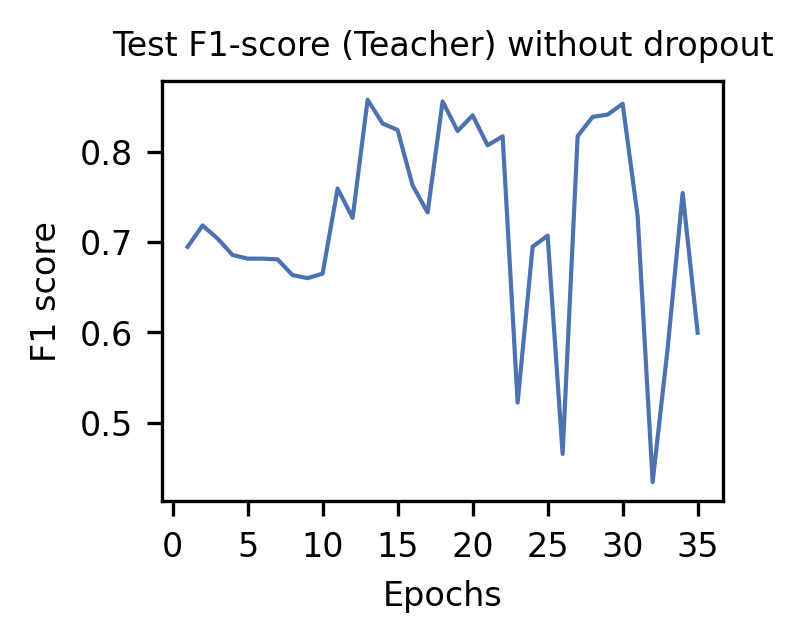

In [ ]:
# Plot the f1 socre vs. epochs curve
color_list = sns.color_palette('deep')
plt.figure(dpi=300,figsize=(2.5,2))
plt.plot(range(1,35+1),inif1t1+finalf1t1,linewidth=1,color = color_list[0])
plt.title('Test F1-score (Teacher) without dropout',fontsize=8)
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('F1 score',fontsize=8)
plt.xticks([0,5,10,15,20,25,30,35],fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.2)


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
plt.savefig('f1_score_t_0dr.jpg',dpi=300)
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
T_dict={'NUM_EPOCHS':35, 'f1_T':inif1t1+finalf1t1}
savemat('f1_T_0dr.mat',T_dict)

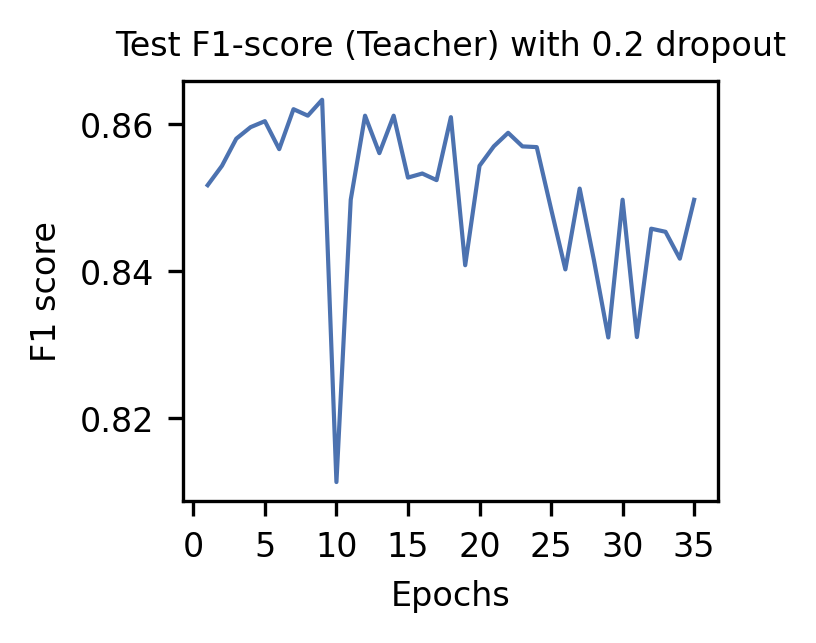

In [ ]:
# Plot the f1 socre vs. epochs curve
color_list = sns.color_palette('deep')
plt.figure(dpi=300,figsize=(2.5,2))
plt.plot(range(1,35+1),inif1t2+finalf1t2,linewidth=1,color = color_list[0])
plt.title('Test F1-score (Teacher) with 0.2 dropout',fontsize=8)
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('F1 score',fontsize=8)
plt.xticks([0,5,10,15,20,25,30,35],fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.2)


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
plt.savefig('f1_score_t_0.2dr.jpg')
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
T_dict={'NUM_EPOCHS':35, 'f1_T':inif1t2+finalf1t2}
savemat('f1_T_0.2dr.mat',T_dict)

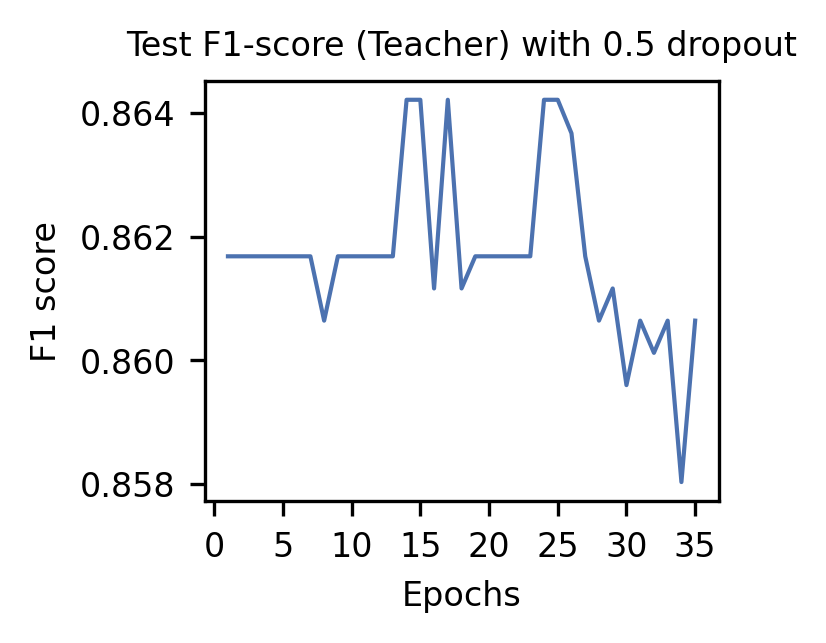

In [ ]:
# Plot the f1 socre vs. epochs curve
color_list = sns.color_palette('deep')
plt.figure(dpi=300,figsize=(2.5,2))
plt.plot(range(1,35+1),inif1t3+finalf1t3,linewidth=1,color = color_list[0])
plt.title('Test F1-score (Teacher) with 0.5 dropout',fontsize=8)
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('F1 score',fontsize=8)
plt.xticks([0,5,10,15,20,25,30,35],fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.2)


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
plt.savefig('f1_score_t_0.5dr.jpg')
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
T_dict={'NUM_EPOCHS':35, 'f1_T':inif1t3+finalf1t3}
savemat('f1_T_0.5dr.mat',T_dict)

In [ ]:
base_student,student_model = student()
ALPHA = 0.7
DISTILLATION_TEMPERATURE = 1
base_student.trainable = False
inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,10,1e-3)
#Fine-tuning
base_student.trainable = True
finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,25,1e-4)

Epoch 1: tf.Tensor(0.38866, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.3800032, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.37596017, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.3732189, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.3712353, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(0.36960346, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(0.36818728, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(0.36693525, shape=(), dtype=float32)
0.8616803278688524
Epoch 9: tf.Tensor(0.36584345, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(0.3649059, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(0.3708546, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.36789268, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.36764297, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.36693066, s

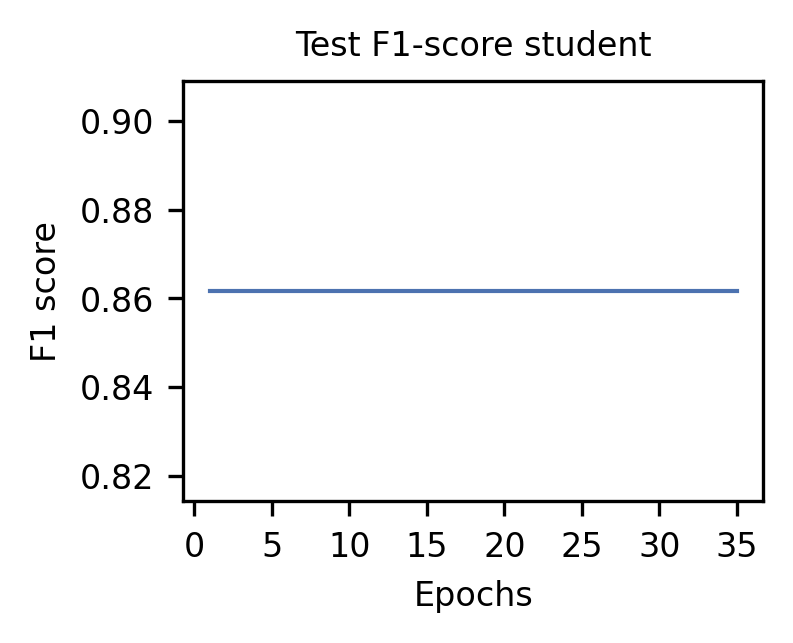

In [6]:
# Plot the f1 socre vs. epochs curve
color_list = sns.color_palette('deep')
plt.figure(dpi=300,figsize=(2.5,2))
plt.plot(range(1,35+1),inif1+finf1,linewidth=1,color = color_list[0])
plt.title('Test F1-score (Teacher) with 0.5 dropout',fontsize=8)
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('F1 score',fontsize=8)
plt.xticks([0,5,10,15,20,25,30,35],fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.2)


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
plt.savefig('f1_score_s_KD.jpg')
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
T_dict={'NUM_EPOCHS':35, 'f1_T':inif1+finf1}
savemat('f1_S_KD.mat',T_dict)

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ACC = []
ALPHA = 0.5
temperatures = [1,2,4,16,32]
for temperature in temperatures:
  DISTILLATION_TEMPERATURE = temperature
  base_student,student_model = student()
  base_student.trainable = False
  inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,10,1e-3)
  #Fine-tuning
  base_student.trainable = True
  finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,25,1e-4)
  ACC.append(inif1+finf1)
  print(ACC[-1])
f1_S_KD = ACC

Epoch 1: tf.Tensor(0.42469022, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.4211837, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.41610357, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.41172236, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.40812945, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(0.4052277, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(0.40286678, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(0.4008473, shape=(), dtype=float32)
0.8616803278688524
Epoch 9: tf.Tensor(0.3990538, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(0.3974221, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(0.4183498, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.41803765, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.41817012, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.41740328,

In [ ]:
ACC = []#This part is for temperature 64 when alpha equals to 0.5
ALPHA = 0.5
temperatures = [64]
for temperature in temperatures:
  DISTILLATION_TEMPERATURE = temperature
  base_student,student_model = student()
  base_student.trainable = False
  inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,10,1e-3)
  #Fine-tuning
  base_student.trainable = True
  finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,25,1e-4)
  ACC.append(inif1+finf1)
  print(ACC[-1])
f1_S_KD = ACC

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1: tf.Tensor(1419.4366, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(1419.4253, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(1419.4204, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(1419.4175, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(1419.4153, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(1419.4136, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(1419.4124, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(1419.411, shape=(), dtype=float32)
0.8616803278688524
Epoch 9: tf.Tensor(1419.4102, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(1419.4093, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(1419.4246, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(1419.4254, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(1419.4271, shape=(), dtype=flo

# Test accuracy vs. alpha and tempreture curve

In [ ]:
ACC = []
temperatures = [1]
alphas = [0.1,0.2,0.3,0.4,0.6]
for alpha in alphas:
  for temperature in temperatures:
    ALPHA = alpha
    DISTILLATION_TEMPERATURE = temperature
    base_student,student_model = student()
    base_student.trainable = False
    inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,10,1e-2)
    #Fine-tuning
    base_student.trainable = True
    finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,25,1e-3)
    ACC.append(finf1[-1])
    print(ACC)
f1_S_KD_T_alpha = ACC

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1: tf.Tensor(0.5421306, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.56810874, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.5238905, shape=(), dtype=float32)
0.8611604702022964
Epoch 4: tf.Tensor(0.5393454, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.5243275, shape=(), dtype=float32)
0.8611604702022964
Epoch 6: tf.Tensor(0.51874155, shape=(), dtype=float32)
0.8571511775669265
Epoch 7: tf.Tensor(0.53943574, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(0.5219632, shape=(), dtype=float32)
0.8611604702022964
Epoch 9: tf.Tensor(0.558965, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(0.540063, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(0.51012737, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.5098976, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.5100103, shape=(), dtype=

In [12]:
# Train the student model
base_student,student_model = student()
ALPHA = 0.8
DISTILLATION_TEMPERATURE = 1
base_student.trainable = False
inif1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,10,1e-3)
#Fine-tuning
base_student.trainable = True
finf1 = train_and_evaluate(teacher_model,student_model,compute_student_loss,25,1e-4)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1: tf.Tensor(0.35264653, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.35229447, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.35245547, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.35268188, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.3527961, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(0.35282886, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(0.3528011, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(0.35285044, shape=(), dtype=float32)
0.8616803278688524
Epoch 9: tf.Tensor(0.35293043, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(0.3530356, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(0.3504631, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.3487923, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.34957883, shape=(), 

# Train student from scratch

In [ ]:
# Build fully connected student.
base_student_scratch = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 
simgs = base_student_scratch.input
smidput = base_student_scratch(simgs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
smidput = keras.layers.GlobalAveragePooling2D()(smidput)
# A Dense classifier with a single unit (binary classification)
soutputs = Dense(2)(smidput)
student_model_scratch = keras.Model(simgs, soutputs)


#test {"output": "ignore"}

def compute_plain_cross_entropy_loss(base_student_scratch,student_model_scratch,images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = student_model_scratch(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,student_subclass_logits)
  
  return cross_entropy_loss

base_student_scratch.trainable = False
inif1_scratch = train_and_evaluate(base_student_scratch,student_model_scratch,compute_plain_cross_entropy_loss,10,1e-3)
#Fine-tuning
base_student_scratch.trainable = True
finf1_scratch = train_and_evaluate(base_student_scratch,student_model_scratch,compute_plain_cross_entropy_loss,25,1e-4)

Epoch 1: tf.Tensor(0.5187392, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.49611378, shape=(), dtype=float32)
0.8611604702022964
Epoch 3: tf.Tensor(0.48384863, shape=(), dtype=float32)
0.8611604702022964
Epoch 4: tf.Tensor(0.47516358, shape=(), dtype=float32)
0.8601190476190477
Epoch 5: tf.Tensor(0.46833315, shape=(), dtype=float32)
0.8601190476190477
Epoch 6: tf.Tensor(0.46269172, shape=(), dtype=float32)
0.8601190476190477
Epoch 7: tf.Tensor(0.45790255, shape=(), dtype=float32)
0.8601190476190477
Epoch 8: tf.Tensor(0.4537611, shape=(), dtype=float32)
0.8595974808324205
Epoch 9: tf.Tensor(0.4501293, shape=(), dtype=float32)
0.8595974808324205
Epoch 10: tf.Tensor(0.44690907, shape=(), dtype=float32)
0.8585526315789473
Epoch 1: tf.Tensor(0.5254731, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.5232217, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.52473867, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.52331465

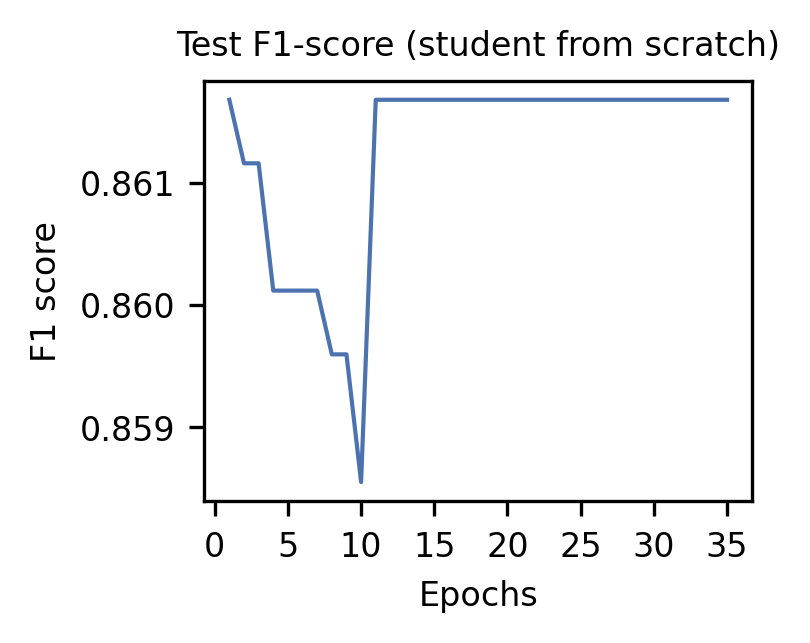

In [ ]:
# Plot the f1 socre vs. epochs curve
color_list = sns.color_palette('deep')
plt.figure(dpi=300,figsize=(2.5,2))
plt.plot(range(1,35+1),inif1_scratch+finf1_scratch,linewidth=1,color = color_list[0])
plt.title('Test F1-score (student from scratch)',fontsize=8)
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('F1 score',fontsize=8)
plt.xticks([0,5,10,15,20,25,30,35],fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.2)


# Save the f1 score vs. epochs curve and data
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
plt.savefig('f1_score_s_scratch.jpg')
os.chdir('/content/drive/MyDrive/ECE1512ProjA')
T_dict={'NUM_EPOCHS':35, 'f1_T':inif1_scratch+finf1_scratch}
savemat('f1_S_scratch.mat',T_dict)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

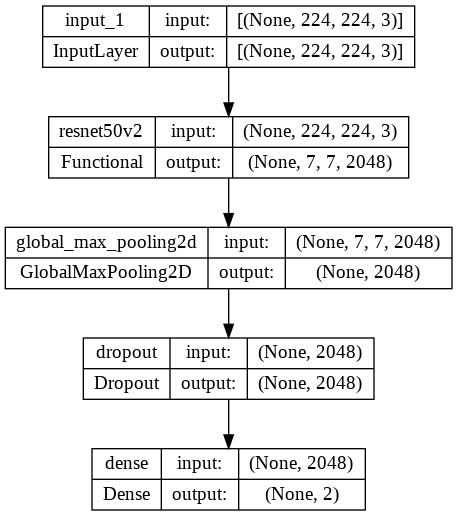

In [ ]:
tf.keras.utils.plot_model(teacher_model, show_shapes=True)

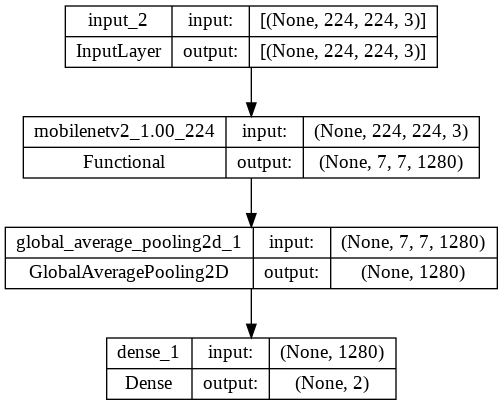

In [ ]:
tf.keras.utils.plot_model(student_model_scratch, show_shapes=True)

In [ ]:
teacher_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
____________________________________________

In [ ]:
student_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
student_model_scratch.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


# Implementing the state-of-the-art KD algorithm

In [15]:
# your code start from here for step 12
from tensorflow import float32
def distillation_loss_EX(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor], epsilon, T_s):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  soft_targets = tf.nn.softmax(teacher_logits/temperature)
  # u = tf.ones_like(soft_targets) / 10.0
  u=0
  zeros = tf.zeros_like(soft_targets)
  distinc_prob = tf.math.maximum(soft_targets-u, zeros)
  norm_fact = tf.reduce_sum(distinc_prob,1,keepdims=True)

  distinc_prob_norm = distinc_prob / norm_fact
  prob = (1-epsilon)*distinc_prob_norm + epsilon*u

  return tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        prob, student_logits / T_s))

In [17]:
def compute_student_loss_EX(images, labels, epsilon, T_s):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model_EX(images, training=True)

  teacher_subclass_logits = teacher_model(images, training=False)
  
  distillation_loss_value = distillation_loss_EX(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE,epsilon,T_s)

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,student_subclass_logits)

  return (BEITA*T_s*distillation_loss_value+GAMMA*cross_entropy_loss_value)

In [29]:
def train_and_evaluate_EX(tmodel,model, compute_loss_fn, NUM_EPOCHS, epsilon, T_s,lr):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  f1 = []
  optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in TRAIN:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels, epsilon, T_s)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
    print(loss_value)
    # Run evaluation.
    PRE = []
    y2 = []
    for X1, y1 in Val:
      predict = model(X1,training=False)
      for i, SET in enumerate(predict):
        if SET[1] > SET[0]:
          PRE.append([0,1])
          y2.append(y1[i])
        else:
          PRE.append([1,0])
          y2.append(y1[i])
    # print(PRE)
    # print(y2)
    f1score = f1_score(y2,PRE,average = "weighted")
    print(f1score)
    f1.append(f1score)

  return f1

In [ ]:
BEITA = 0.2
GAMMA = 0.2
DISTILLATION_TEMPERATURE = 2
base_EX,fc_model_EX = student()
base_EX.trainable = False
inif1 = train_and_evaluate_EX(teacher_model,fc_model_EX,compute_student_loss_EX,10,0,1,1e-3)
base_EX.trainable = True
finf1 = train_and_evaluate_EX(teacher_model,fc_model_EX,compute_student_loss_EX,25,0,1,1e-4)

Epoch 1: tf.Tensor(0.21336283, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.21242252, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.2120515, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.21183473, shape=(), dtype=float32)
0.8616803278688524
Epoch 5: tf.Tensor(0.2116524, shape=(), dtype=float32)
0.8616803278688524
Epoch 6: tf.Tensor(0.2114911, shape=(), dtype=float32)
0.8616803278688524
Epoch 7: tf.Tensor(0.2113281, shape=(), dtype=float32)
0.8616803278688524
Epoch 8: tf.Tensor(0.21118185, shape=(), dtype=float32)
0.8616803278688524
Epoch 9: tf.Tensor(0.21102574, shape=(), dtype=float32)
0.8616803278688524
Epoch 10: tf.Tensor(0.21088901, shape=(), dtype=float32)
0.8616803278688524
Epoch 1: tf.Tensor(0.21133992, shape=(), dtype=float32)
0.8616803278688524
Epoch 2: tf.Tensor(0.21122688, shape=(), dtype=float32)
0.8616803278688524
Epoch 3: tf.Tensor(0.21079764, shape=(), dtype=float32)
0.8616803278688524
Epoch 4: tf.Tensor(0.2106796

# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
